In [ ]:
import os, sys
sys.path.append(os.path.abspath('../utils'))

import numpy as np
import math
import matplotlib.pyplot as plt  
import matplotlib.gridspec as gridspec

# Utility functions
import dca_fs_tools as dcat

# Enable LaTeX in Matplotlib
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Description of synthetic data sets used in the examples

We use three synthetic data sets:

*  **Well-specified LR**: This set has standard normaliy distributed indpendent variables and an outcome deriving from a log-odds that is a linear combination of the independent variables. The coeficients are specified *ab initio*. This is used to benchmark pytorch implementations of the weighted LASSO logistic regressions with both cross-entropy and maximum-mean-net-benefit loss functions. Used in [01_net_benefit_loss_function](./01_net_benefit_loss_function.ipynb).

* **Ill-specified LR**: This set is the same as the one above except that heteroscadicity is imposed on the linear combination of coefficients before calculating the outcome probability. This makes a LR model ill-specified and introduces an asymetry in positive and negative outcomes. This is used to benchmark the maximum-mean-net-benefit loss function. Used in [01_net_benefit_loss_function](./01_net_benefit_loss_function.ipynb).

* **Scikit learn's make_classification**: This is scikit learns implementation of a synthetic classification problem dataset. This is used to compar the net-benefit-based feature selection methods. Used in [02_net_benefit_regularization_method](./01_net_benefit_regularization_method.ipynb),  [03_feature_importance_iterative_method](./01_feature_importance_iterative_method.ipynb), and [04_backward_stepwise_method](./01_backward_stepwise_method.ipynb)

Each of these is illustrated and described below in more detail.

## Well-specified LR synthetic data

This dataset is generated with a call to the following utility function, with parameters:

* **n_features**: The number of independent variables in the dataset
* **n_sample**: The size of the sample
* **true_coefs**: The true LR coefficients
* **true_bias**: The true bias (intercept)

The **heteros** parameter will be described in the next section

In [2]:
n_sample = 100000
true_params = [1.7, 0.8, -0.4]

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    dcat.make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = true_params, true_bias=0.0, heteros=0.)

This data set has standard normaly distributed independent variables:

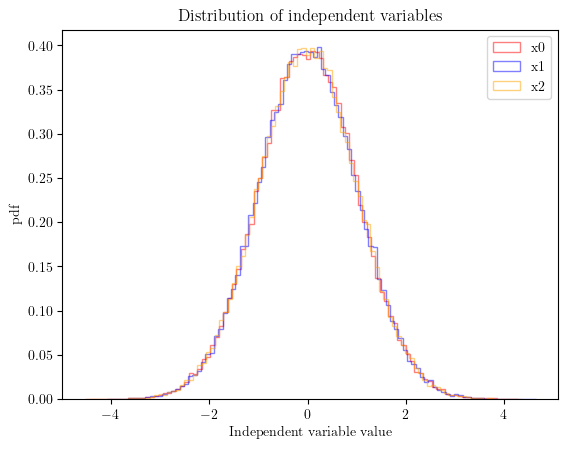

In [3]:
fig, ax = plt.subplots()
kwargs = dict(alpha=0.5, bins=100)
ax.hist(df_train["x0"], **kwargs, label = "x0", histtype=u'step', density=True, color="red")
ax.hist(df_train["x1"], **kwargs, label = "x1", histtype=u'step', density=True, color="blue")
ax.hist(df_train["x2"], **kwargs, label = "x2", histtype=u'step', density=True, color="orange")
ax.set_xlabel("Independent variable value")
ax.set_ylabel("pdf")
ax.set_title("Distribution of independent variables")
plt.legend()
plt.show()

The log-odds is given by the linear combination of the independent variables with the specified coefficients. This allows us to know the true value of the coefficients in a well-specified LR and is helpful for comparing inferred parameters to their true values.

$$\text{Log-odds} = \sum_{i=0}^{n_{\text{features}}-1}  \beta_i x_i$$

Where the $\beta_i$ are the pre-specified parameters and the $x_i$ are the indpeendent variables.

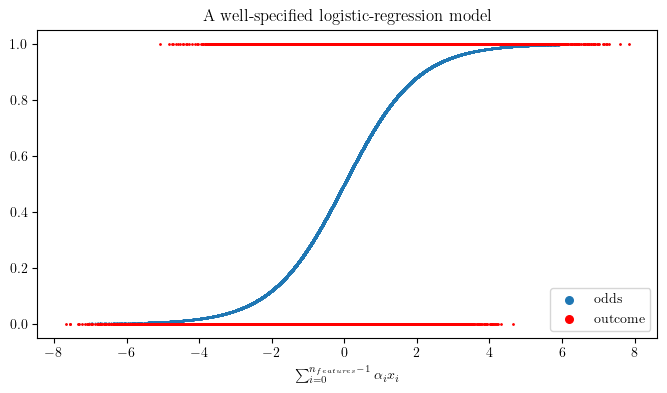

In [ ]:
df_train["x"] = 0
for n, v in enumerate(ind_var_names):
    df_train["x"] += true_params[n]*df_train[v]
    
df_train["p"] = df_train.apply(lambda row: 1./(1. + math.exp(-row["x"])), axis=1)

fig, ax1 = plt.subplots(figsize = (8,4))  

ax1.scatter("x", "p",data = df_train, s=0.1, label = "odds")
ax1.scatter("x", "y",data = df_train, s=1.0, color = "red", label = "outcome")

lgnd = plt.legend(loc="lower right", scatterpoints=1, fontsize=10)
#lgnd.legendHandles[0]._sizes = [30]
#lgnd.legendHandles[1]._sizes = [30]
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]


#ax1.set_xlabel("True log-odds")
ax1.set_xlabel(r"$\sum_{i=0}^{n_{features}-1}  \beta_i x_i $")

ax1.set_ylabel("")
ax1.set_title("A well-specified logistic-regression model")

plt.show()

## Ill-specified LR

This is closely related to the data set described above but includes a non-zero value of the heteroscadicity parameter:

* **heteros**: The degree of heteoscadicity to add to the linear combination of coefficients before calculating the log-odds.

In [5]:
n_sample = 100000
true_params = [1.7, 0.8, -0.4]

df_train_h, df_test_h, df_noisy_train_h, df_noisy_test_h, ind_var_names_h, n_features_h, true_coefs_h = \
    dcat.make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = true_params, true_bias=0.0, heteros=2.5)

The relation between the linear combination of coefficients and the log-odds is shown bellow:

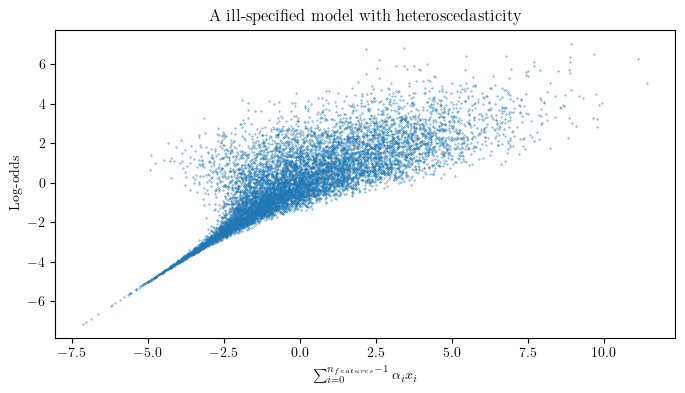

In [ ]:
df_train_h["x"] = 0
for n, v in enumerate(ind_var_names_h):
    df_train_h["x"] += true_params[n]*df_train_h[v]
    
heteros = 2.5
# add heteroscedacity
df_train_h["h"] = df_train_h.apply(lambda row: row["x"] + heteros * np.random.normal(loc=0, scale = 1./(1.+np.exp(-row["x"])) ), axis=1)

df_train_h["p"] = df_train_h.apply(lambda row: 1./(1. + math.exp(-row["x"])), axis=1)

fig, ax1 = plt.subplots(figsize = (8,4))  




ax1.scatter("h", "x",data = df_train_h.sample(10000), s=0.1, label = "log-odds")

#ax1.set_xlabel("True log-odds")

#ax1.set_xlabel(r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16)
ax1.set_xlabel(r"$\sum_{i=0}^{n_{features}-1}  \beta_i x_i $")

ax1.set_ylabel("Log-odds")
ax1.set_title("A ill-specified model with heteroscedasticity")

plt.show()

This dataset includes an asymetry between positives and negatives and is used to explore the effect of the maximum-mean-net-benefit loss function in [01_net_benefit_loss_function](./01_net_benefit_loss_function.ipynb).

## Scikit learn's make_classification

The final synthetic data set we use in these examples is based on scikit learn's make_classification function. We use this to make a random 2-class classification problem. Data points are normaly distributed (std=1) on a hypercube. 

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

This dataset is generated with a call to the following utility function, with parameters:

* **n_sample**: The size of the sample
* **n_features**: The number of independent variables in the dataset
* **n_redundant**: The number of redundant features
* **n_informative**: The number of informative features
* **n_clusters_per_class**: The number of clusters per class
* **n_classes**: The number of classes in the resulting classification problem

In [7]:
n_sample = 1000

df_train_skl, df_test_skl, ind_var_names_skl = dcat.make_class_dataset(n_sample = n_sample,
                                       n_features = 5,
                                       n_redundant = 0,
                                       random_state = 1001,
                                       n_informative = 4,
                                       n_clusters_per_class = 1,
                                       n_classes = 2)

This dataset is visualised below:

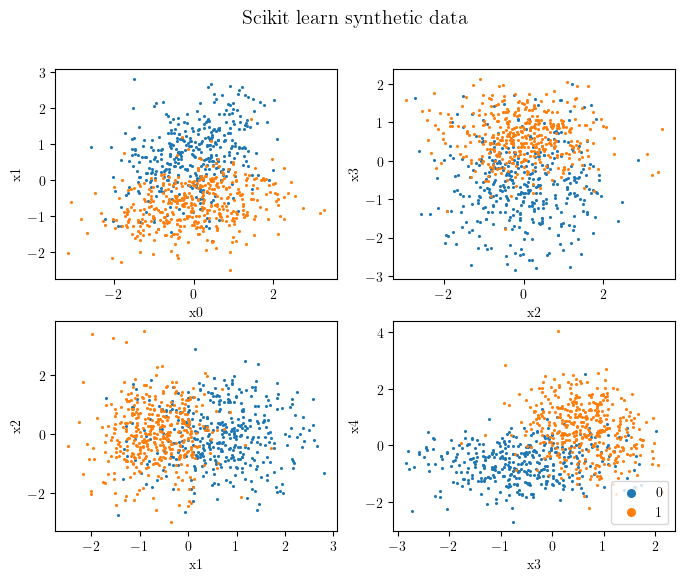

In [8]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])

groups = df_train_skl.groupby('y')
for name, group in groups:
    ax1.scatter(group.x0, group.x1, marker='o', s=1.5, label=name)
    ax2.scatter(group.x1, group.x2, marker='o', s=1.5, label=name)
    ax3.scatter(group.x2, group.x3, marker='o', s=1.5, label=name)
    ax4.scatter(group.x3, group.x4, marker='o', s=1.5, label=name)

lgnd = ax4.legend(loc = "lower right", scatterpoints=1, fontsize=10)

lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]

ax1.set_xlabel("x0")
ax1.set_ylabel("x1")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax3.set_xlabel("x2")
ax3.set_ylabel("x3")
ax4.set_xlabel("x3")
ax4.set_ylabel("x4")
fig.suptitle("Scikit learn synthetic data", fontsize="x-large")
plt.show()